In [1]:
# Standard Math / Data libraries
import numpy as np
import pandas as pd

# Data Scrape Package
import pandas_datareader.data as web

# Plotting package
import matplotlib.pyplot as plt
# Scaling Package
from sklearn.preprocessing import MinMaxScaler

# Keras Network @ https://www.tensorflow.org/guide/keras/gru
import tensorflow as tf # version tensorflow==2.4.0
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow.keras import layers

import yfinance as yf
yf.pdr_override()

In [2]:
tick = 'GOOG'
google = web.get_data_yahoo(tick,'2015-11-04', '2020-11-04')

[*********************100%%**********************]  1 of 1 completed


In [3]:
google.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-11-04,36.099998,36.654999,36.095001,36.405499,36.405499,34134000
2015-11-05,36.473499,36.973999,36.473499,36.562500,36.562500,37232000
2015-11-06,36.575001,36.770500,36.350498,36.688000,36.688000,30232000
2015-11-09,36.509998,36.735500,35.971500,36.244499,36.244499,41396000
2015-11-10,36.220001,36.529499,35.924999,36.416000,36.416000,32160000


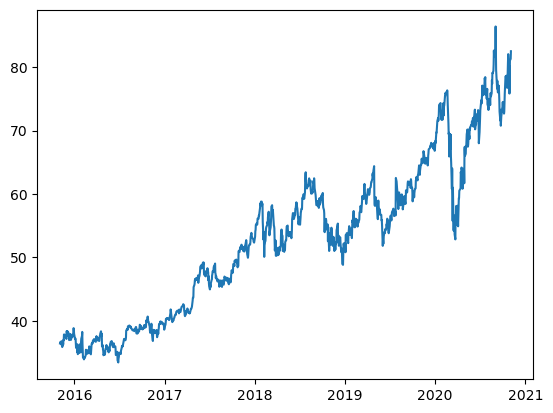

In [4]:
plt.plot(google['Adj Close'])


In [5]:
returns = google['Adj Close'].pct_change() # Used for univariate example.

column_names = google.columns
x = google.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)

In [6]:
pct_c_google = df

In [7]:
pct_c_google.columns = column_names

In [8]:
pct_c_google.head()


,Open,High,Low,Close,Adj Close,Volume
0,0.051974,0.057311,0.058648,0.056461,0.056461,0.226511
1,0.059144,0.063325,0.066194,0.059423,0.059423,0.252325
2,0.061092,0.059488,0.063742,0.061791,0.061791,0.193997
3,0.059845,0.058829,0.056186,0.053424,0.053424,0.287021
4,0.054278,0.054945,0.055259,0.056659,0.056659,0.210062


# Predict future prices in GOOG (Multivariate Forecasting) using GRU

In [9]:
returns


Date
2015-11-04         NaN
2015-11-05    0.004313
2015-11-06    0.003432
2015-11-09   -0.012088
2015-11-10    0.004732
                ...   
2020-10-28   -0.054630
2020-10-29    0.033377
2020-10-30    0.034309
2020-11-02    0.003097
2020-11-03    0.014871
Name: Adj Close, Length: 1259, dtype: float64

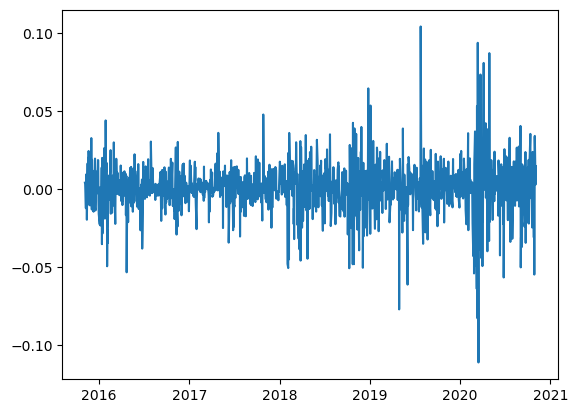

In [10]:
plt.plot(returns)


<Axes: >

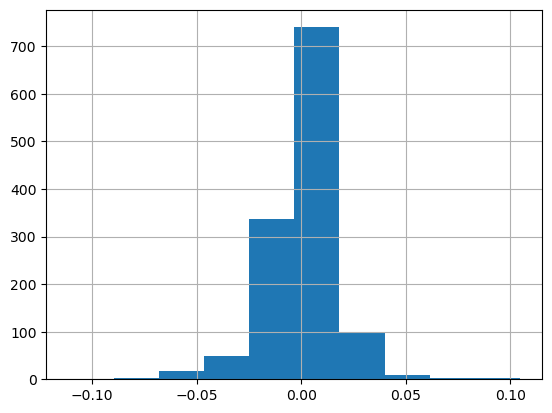

In [11]:
returns.hist()

In [12]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(pct_c_google.shape[0] - samples):
    X.append(pct_c_google.iloc[i:i+samples, 0:5].values) # Independent Samples
    Y.append(pct_c_google.iloc[i+samples, 5:].values) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  10 :  [array([[0.05197409, 0.05731086, 0.05864825, 0.0564612 , 0.0564612 ],
       [0.05914395, 0.06332474, 0.06619354, 0.05942344, 0.05942344],
       [0.06109241, 0.05948833, 0.06374153, 0.06179131, 0.06179131],
       [0.05984459, 0.0588285 , 0.05618628, 0.05342354, 0.05342354],
       [0.05427771, 0.05494491, 0.05525929, 0.05665935, 0.05665935],
       [0.06201384, 0.06475752, 0.0669511 , 0.06333847, 0.06333847],
       [0.06061247, 0.06174116, 0.06537126, 0.05940458, 0.05940458],
       [0.05885601, 0.05547277, 0.05349504, 0.04598027, 0.04598027],
       [0.04583126, 0.05390803, 0.04811271, 0.05726314, 0.05726314],
       [0.0589712 , 0.05612792, 0.05977151, 0.05381032, 0.05381032]])]
Testing Data: Length is  1 :  [array([0.22277772])]


In [13]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

Dimensions of X (1249, 10, 5) Dimensions of Y (1249, 1)


In [14]:
# # Get the training and testing set
threshold = round(0.9 * X.shape[0])
trainX, trainY = X[:threshold], Y[:threshold]
testX, testY =  X[threshold:], Y[threshold:]
print('Training Length',trainX.shape, trainY.shape,'Testing Length:',testX.shape, testY.shape)

Training Length (1124, 10, 5) (1124, 1) Testing Length: (125, 10, 5) (125, 1)


In [15]:
# Let's build the GRU
model = keras.Sequential()

# Add a GRU layer with 15 units.
model.add(layers.GRU(15,
                     activation = "tanh",
                     recurrent_activation = "sigmoid",
                     input_shape=(X.shape[1], X.shape[2])))

# Add a dropout layer (penalizing more complex models) -- prevents overfitting
model.add(layers.Dropout(rate=0.2))


# Add a Dense layer with 1 units (Since we are doing a regression task.
model.add(layers.Dense(1))

# Evaluating loss function of MSE using the adam optimizer.
model.compile(loss='mean_squared_error', optimizer = 'adam')

# Print out architecture.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15)                990       
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 1006 (3.93 KB)
Trainable params: 1006 (3.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# Fitting the data
history = model.fit(trainX,
                    trainY,
                    shuffle = False, # Since this is time series data
                    epochs=500,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1) # Verbose outputs data

Epoch 1/500
29/29 [==============================] - 1s 10ms/step - loss: 0.0498 - val_loss: 0.0198
Epoch 2/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0381 - val_loss: 0.0203
Epoch 3/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0275 - val_loss: 0.0183
Epoch 4/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0256 - val_loss: 0.0178
Epoch 5/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0227 - val_loss: 0.0177
Epoch 6/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0219 - val_loss: 0.0179
Epoch 7/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0203 - val_loss: 0.0177
Epoch 8/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0197 - val_loss: 0.0178
Epoch 9/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0192 - val_loss: 0.0177
Epoch 10/500
29/29 [==============================] - 0s 3ms/step - loss: 0.0195 - val_loss: 0.0175
Epoch 11

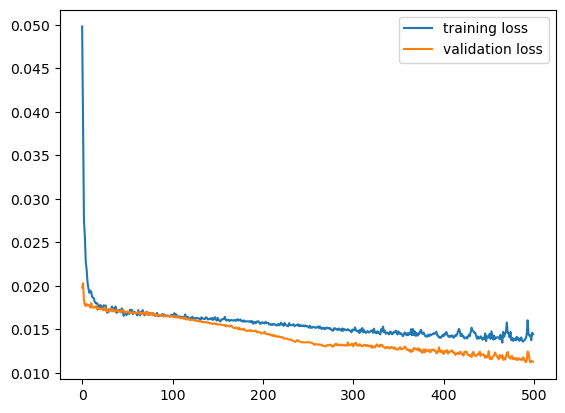

In [17]:
# Plotting the loss iteration
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()

4/4 [==============================] - 0s 1ms/step


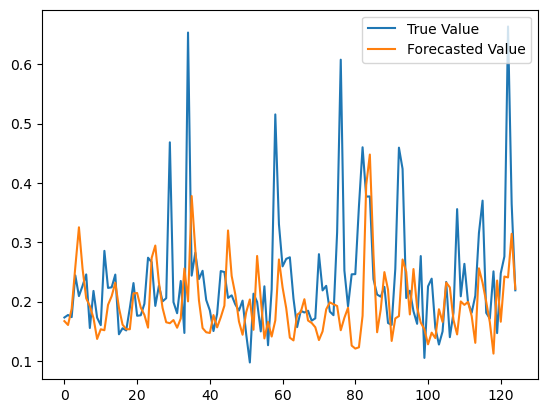

In [18]:
y_pred = model.predict(testX)
plt.plot(testY, label = 'True Value')
plt.plot(y_pred, label = 'Forecasted Value')
plt.legend()